In [8]:
#################################           Load libs                      #############################################
import os
import json
import pickle
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib as mpl

mpl.use('TkAgg') # to fix problem on Mac OS
import matplotlib.pyplot as plt
%matplotlib inline

# Set main directory
main_dir = os.path.dirname(os.getcwd())
os.chdir(main_dir)

from src.utils import metrics_eval, Timer, save_image
from src.data.data_processor import DataProcessor
from src.model.model import Model

In [20]:
#################################         Load data                      #############################################

timer = Timer()

# Import targets
target = pd.read_csv(main_dir + "/data/series_g.csv", sep=";").series_g.values
# target = pd.read_csv("data/monthly-beer-production-in-austr.csv", sep=",").iloc[:, -1].values
# target = pd.read_csv("data/Electric_Production.csv", sep=",").iloc[:, -1].values
# target = pd.read_csv("data/Chicago_hotels.csv", sep="\t").iloc[:, 3].values
# target = pd.read_csv("data/PJME_hourly.csv", sep=",").PJME_MW.values

# Generate factors
f1 = np.arange(1, len(target) + 1).reshape(-1, 1)
f2 = (np.arange(1, len(target) + 1) ** 2).reshape(-1, 1)

# factors = f1
factors = np.hstack((f1, f2))

In [65]:
#################################         Set params                    #############################################

# Load description of experiment
# configs = json.load(open(main_dir + '/src/config.json', 'r'))

# or 
configs ={
        "test_len": 12,
        "prediction_len": 12,
        "factors": True,

        "training": {
            "epochs": 50,
            "batch_size": 1
        },
        "model": {
            "loss": "mse",
            "optimizer": "adam",
            "n_step_out": 12,
            "layers": [
                {
                    "type": "GRU",
                    "neurons": 20,
                    "n_step_in": 12,
                    "return_sequences": False
                },
                {
                    "type": "Dropout",
                    "rate": 0.2
                },
                {
                    "type": "Dense",
                    "activation": "linear"
                }
            ]
        }
    }

my_callbacks = None

# my_callbacks = [callbacks.EarlyStopping(patience=4,
#                                      monitor='val_loss',
#                                      # min_delta=0
#                                      )]

In [66]:
#################################           Model training                ##############################################
from keras import callbacks

#Set classes
model = Model()
data_processor = DataProcessor()

# scaler fitting
target_std = data_processor.scaler_fit_transform(target, target=True)

# Making input
if configs["factors"]:
    factors_std = data_processor.scaler_fit_transform(factors, target=False)
    input_df = np.hstack((factors_std, target_std))
else:
    input_df = target_std

# Set number of features
model.n_features = input_df[0].size

# Building model
model.build_model(configs)
pprint(model.params)
model.model.summary()

# Train/ Test split
train, test = data_processor.train_test_split(input_df, test_len=configs["test_len"])

# split into samples
if configs["factors"] and (configs["model"]["n_step_out"] == 1):
    ALL = True
else:
    ALL = False

X_train, y_train = data_processor.split_sequence(train,
                                                n_steps_in=model.n_step_in,
                                                n_steps_out=configs["model"]["n_step_out"],
                                                all=ALL)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], model.n_features))

# Making validation_data for training plot

if configs["test_len"] == 0:
    X_test, y_test = None, None

    model.fit(x_train=X_train,
              y_train=y_train,
              epochs=configs["training"]["epochs"],
              batch_size=configs["training"]["batch_size"],
              callbacks = my_callbacks,
              verbose=2)

else:
    X_test, y_test = data_processor.split_sequence(input_df,
                                                    n_steps_in=model.n_step_in,
                                                    n_steps_out=configs["model"]["n_step_out"], all=ALL)
    X_test = X_test[-len(test):]
    y_test = y_test[-len(test):]
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], model.n_features))

    model.fit(x_train=X_train,
              y_train=y_train,
              epochs=configs["training"]["epochs"],
              batch_size=configs["training"]["batch_size"],
              x_test=X_test,
              y_test=y_test,
              callbacks = my_callbacks,
              verbose=2)

[Model] Model Compiled
Time taken: 0:00:00.250558
{'factors': True,
 'model': {'layers': [{'n_step_in': 12,
                       'neurons': 20,
                       'return_sequences': False,
                       'type': 'GRU'},
                      {'rate': 0.2, 'type': 'Dropout'},
                      {'activation': 'linear', 'type': 'Dense'}],
           'loss': 'mse',
           'n_step_out': 12,
           'optimizer': 'adam'},
 'prediction_len': 12,
 'test_len': 12,
 'training': {'batch_size': 1, 'epochs': 50}}
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 20)                1440      
_________________________________________________________________
dropout_17 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 12)           

In [67]:
#################################   Making new folder with results        ##############################################

path = main_dir + "/reports"

try:
    os.chdir(path)
except:
    os.makedirs(path)
    os.chdir(path)
new_folder_num = str(len(os.listdir()) + 1)
new_folder = "%s/%s" % (path, new_folder_num)
os.mkdir(new_folder)

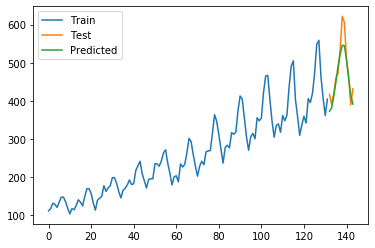

Mean Absolute Error: 25.531
Mean Squared Error: 1206.833
Root Mean Squared Error: 34.74
Mean absolute percentage error: 5.132
Scaled Mean absolute percentage error: 5.317


In [68]:
#################################           Prediction                    ##############################################

predicted = model.predict(train[-model.n_step_in:])

# inverse transform
predicted = data_processor.scaler_inverse_transform(predicted, target=True)
train = data_processor.scaler_inverse_transform(train[:, -1], target=True)
if configs["test_len"] != 0:
    test = data_processor.scaler_inverse_transform(test[:, -1], target=True)

#################################     Printing results and plots        ################################################


plt.plot(range(len(train)), train, label="Train")
if configs["test_len"] != 0:
    plt.plot(range(len(train), len(train) + len(test)), test, label="Test")
plt.plot(range(len(train), len(train) + len(predicted)), predicted, label="Predicted")
plt.legend()
save_image(new_folder, "train_test_predicted", fmt="png")
plt.show()
plt.close()

if configs["test_len"] != 0 and len(test) >= len(predicted):
    mae, mse, rmse, MAPE, SMAPE = metrics_eval(test[:len(predicted)], predicted)
    with open(new_folder + '/metrics_%s.txt' % (model.id), 'w') as record_file:
        record_file.write('Mean Absolute Error:' + str(round(mae, 3)))
        record_file.write('\nMean Squared Error:' + str(round(mse, 3)))
        record_file.write('\nRoot Mean Squared Error:' + str(round(rmse, 3)))
        record_file.write('\nMean absolute percentage error:' + str(round(MAPE, 3)))
        record_file.write('\nScaled Mean absolute percentage error:' + str(round(SMAPE, 3)))
        record_file.close()

In [24]:
#################################            Saving                     ################################################

# Save classes
with open(new_folder + '/model.pickle', 'wb') as record_file:
    pickle.dump(model, record_file)
    record_file.close()

with open(new_folder + '/data_processor.pickle', 'wb') as record_file:
    pickle.dump(data_processor, record_file)
    record_file.close()

# Config saving
with open(new_folder + "/configs_%s.json" % model.id, "w") as record_file:
    json.dump(model.params, record_file)